# Parameter estimation using ordinal data

This Notebook explains the use of ordinal data for parameter estimation, as described in [Schmiester et al. (2020)](https://doi.org/10.1007/s00285-020-01522-w) and [Schmiester et al. (2021)](https://doi.org/10.1093/bioinformatics/btab512). 
An example model is provided in `pypesto/doc/example/example_ordinal`.

Ordinal data is defined as the data for which the mutual ordering of the measurements is known. The implementation allows for indistinguishable measurements, i.e. multiple measurements which cannot be ordinally distinguished from each other and are part of the same ordinal level.

For the integration of ordinal data, we employ the optimal scaling approach. In this approach, each ordinal datapoint is defined as being part of a category, where the mutual ordering of categories of the same observable is known. The category interval bounds are numerically optimized and quantitative surrogate measurements are calculated to represent the ordinal measurements. This constitutes the inner subproblem of the hierarchical optimization problem.

Details on the optimal scaling approach can be found in Shepard, 1962 (https://doi.org/10.1007/BF02289621).
Details on the application of the gradient-based optimal scaling approach to mechanistic modeling
with ordinal data can be found in Schmiester et al. 2020 (https://doi.org/10.1007/s00285-020-01522-w)
and Schmiester et al. 2021 (https://doi.org/10.1093/bioinformatics/btab512).

## Import model from the petab_problem

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
import pypesto.logging
import pypesto.optimize as optimize
from pypesto.hierarchical.optimal_scaling import OptimalScalingInnerSolver
from pypesto.petab import PetabImporter
from pypesto.visualize import plot_categories_from_pypesto_result

To use ordinal data for parameter estimation, in pyPESTO we use the optimal scaling approach as in the referenced papers. Since the optimal scaling approach is implemented in the hierarchical manner, it requires us to specify `hierarchical=True` when importing the `petab_problem`:

In [2]:
petab_folder = './example_ordinal/'
yaml_file = 'example_ordinal.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

importer = PetabImporter(petab_problem, hierarchical=True)

The `petab_problem` has to be specified in the usual PEtab formulation. The ordinal measurements have to be specified in the `measurement.tsv` file by adding `ordinal` in the `measurementType` column, and the ordering of measurements has to be specified in the `measurementCategory` column by assigning each measurement to a category:

In [3]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(petab_problem.measurement_df)

,observableId,preequilibrationConditionId,simulationConditionId,measurement,time,observableParameters,noiseParameters,observableTransformation,noiseDistribution,measurementType,measurementCategory
0,Activity,NaN,Inhibitor_0,0,5,NaN,1,lin,normal,ordinal,2
1,Activity,NaN,Inhibitor_3,0,5,NaN,1,lin,normal,ordinal,2
2,Activity,NaN,Inhibitor_10,0,5,NaN,1,lin,normal,ordinal,3
3,Activity,NaN,Inhibitor_25,0,5,NaN,1,lin,normal,ordinal,3
4,Activity,NaN,Inhibitor_35,0,5,NaN,1,lin,normal,ordinal,2
5,Activity,NaN,Inhibitor_50,0,5,NaN,1,lin,normal,ordinal,1
6,Activity,NaN,Inhibitor_75,0,5,NaN,1,lin,normal,ordinal,1
7,Activity,NaN,Inhibitor_100,0,5,NaN,1,lin,normal,ordinal,1
8,Activity,NaN,Inhibitor_300,0,5,NaN,1,lin,normal,ordinal,1
9,Ybar,NaN,Inhibitor_0,0,5,NaN,1,lin,normal,ordinal,1


For ordinal measurements, the `measurement` column will be ignored.

Measurements with a larger category number will be constrained to be higher in the ordering. Multiple measurements can be assigned to the same category. If this is done, these measurements will be treated as indistinguishable. 

#### Note on inclusion of additional data types:
It is possible to include observables with different types of data to the same `petab_problem`. Refer to the notebooks on using [nonlinear-monotone data](nonlinear_monotone.ipynb) and [censored data](censored.ipynb) for details on integration of other data types. If the `measurementType` column is left empty for all measurements of an observable, the observable will be treated as quantitative.

## Construct the objective and pypesto problem

Different options can be used for the optimal scaling approach:

- method: `standard` / `reduced`
- reparameterized: `True` / `False`
- interval_constraints: `max` / `max-min`
- min_gap: Any float value

It is recommended to use the reduced method with reparameterization as it is the most efficient and robust choice.

When no options are provided, the default is the reduced and reparameterized formulation with max as interval constraint and `min_gap=1e-16`.

Now when we construct the `objective`, it will construct all objects of the optimal scaling inner optimization:

- `OptimalScalingInnerSolver`
- `OptimalScalingAmiciCalculator`
- `OptimalScalingProblem`

Specifically, the `OptimalScalingInnerSolver` will be constructed with default settings.  

In [4]:
objective = importer.create_objective()

To give non-default options to the `OptimalScalingInnerSolver` and `OptimalScalingProblem`, one can pass them as arguments when constructing the `objective`:

In [5]:
objective = importer.create_objective(
    inner_options={
        "method": 'reduced',
        "reparameterized": True,
        "interval_constraints": "max",
        "min_gap": 0.1,
    },
)

Alternatively, we could've even given them to the `importer constructor`, they would be passed all the way to the inner solver.

Now let's construct the pyPESTO problem and optimizer. We're going to use a gradint-based optimizer for a faster optimization, but gradient-free optimizers can be used in the same way:

In [6]:
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

optimizer = optimize.ScipyOptimizer(
    method="L-BFGS-B",
    options={"disp": None, "ftol": 2.220446049250313e-09, "gtol": 1e-5},
)
n_starts = 10
np.random.seed(n_starts)

## Run optimization using optimal scaling approach

If we want to change options of the `OptimalScalingInnerSolver` a new instance of it with new options can be passed to the correct inner calculator. Since in our problem there is only one data type and so one inner problem, we pass it to the first inner calculator  `problem.objective.calculator.inner_calculators[0]`.

In case of multiple inner problems, one would have to check the instance of the inner calculator, find the `OptimalScalingAmiciCalculator` and pass the new inner solver to it.

#### Run optimization using the reduced and reparameterized approach

In [7]:
np.random.seed(n_starts)
problem.objective.calculator.inner_calculators[
    0
].inner_solver = OptimalScalingInnerSolver(
    options={
        'method': 'reduced',
        'reparameterized': True,
        'interval_constraints': 'max',
        'min_gap': 1e-10,
    }
)

res_reduced_reparameterized = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


#### Run optimization using the reduced non-reparameterized approach

In [8]:
np.random.seed(n_starts)
problem.objective.calculator.inner_calculators[
    0
].inner_solver = OptimalScalingInnerSolver(
    options={
        'method': 'reduced',
        'reparameterized': False,
        'interval_constraints': 'max',
        'min_gap': 1e-10,
    }
)

res_reduced = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


#### Run optimization using the standard approach

In [9]:
np.random.seed(n_starts)
problem.objective.calculator.inner_calculators[
    0
].inner_solver = OptimalScalingInnerSolver(
    options={
        'method': 'standard',
        'reparameterized': False,
        'interval_constraints': 'max',
        'min_gap': 1e-10,
    }
)

res_standard = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


## Compare results

Reduced formulation leads to improved computation times

In [10]:
time_standard = res_standard.optimize_result.get_for_key('time')
print(f"Mean computation time for standard approach: {np.mean(time_standard)}")

time_reduced = res_reduced.optimize_result.get_for_key('time')
print(f"Mean computation time for reduced approach: {np.mean(time_reduced)}")

time_reduced_reparameterized = (
    res_reduced_reparameterized.optimize_result.get_for_key('time')
)
print(
    f"Mean computation time for reduced reparameterized approach: {np.mean(time_reduced_reparameterized)}"
)

Mean computation time for standard approach: 0.9591359615325927
Mean computation time for reduced approach: 0.9587480783462524
Mean computation time for reduced reparameterized approach: 0.9444998025894165


All approaches yield the same objective function values

<AxesSubplot: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=9.994e-01)'>

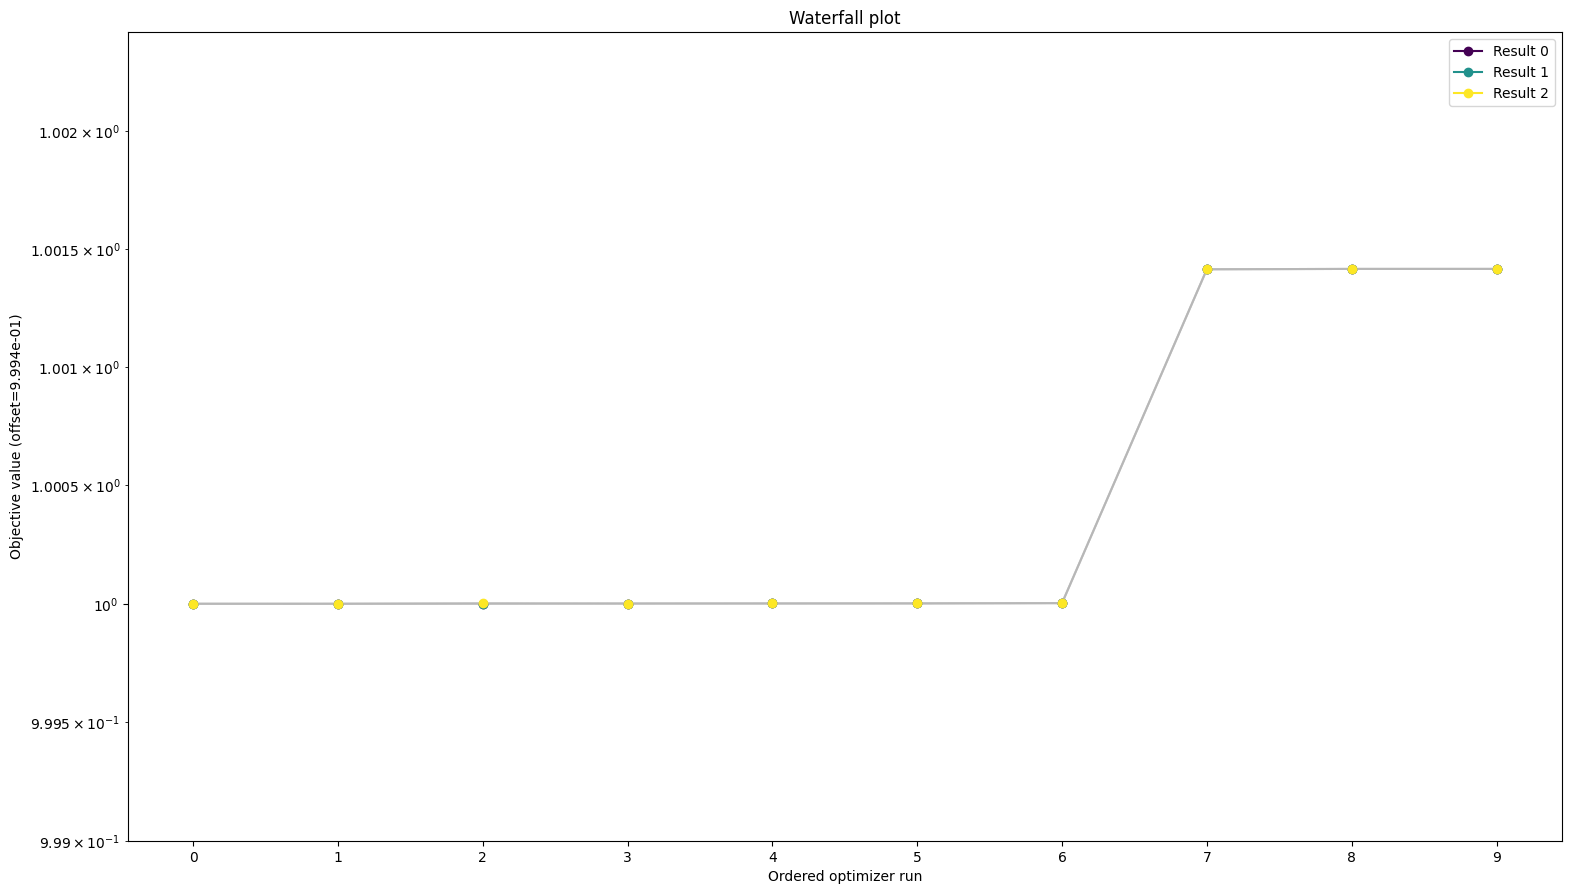

In [11]:
from pypesto.visualize import waterfall

waterfall(
    [res_standard, res_reduced, res_reduced_reparameterized], order_by_id=True
)

To be sure the function values are the same we can look at them directly as well:

In [12]:
for start_id in range(10):
    print(
        [
            [
                res.fval
                for res in result.optimize_result.as_list()
                if res.id == str(start_id)
            ]
            for result in [
                res_standard,
                res_reduced,
                res_reduced_reparameterized,
            ]
        ]
    )

[[0.0019888825676075647], [0.001988882370072136], [0.001988882910838056]]
[[0.0005749912862480574], [0.000574991288188709], [0.0005749912568270656]]
[[0.0019873258450258152], [0.00198732584677828], [0.001987325844380883]]
[[0.000575277818265601], [0.0005752778595524745], [0.0005752778031689591]]
[[0.001988829061937092], [0.0019888290614633627], [0.0019888291358973434]]
[[0.0005764328010595188], [0.0005764329969969911], [0.0005764329960499568]]
[[0.0005747398568712971], [0.0005747398648398072], [0.0005747398437695331]]
[[0.0005735607865200714], [0.0005737543524337683], [0.0005767971102241927]]
[[0.0005735594279397531], [0.0005735611260351738], [0.0005741377033402549]]
[[0.0005735572044450639], [0.000573961371293838], [0.0005736263264256104]]


For any results, we can plot the optimized categories using the `plot_categories_from_pypesto_result` method.

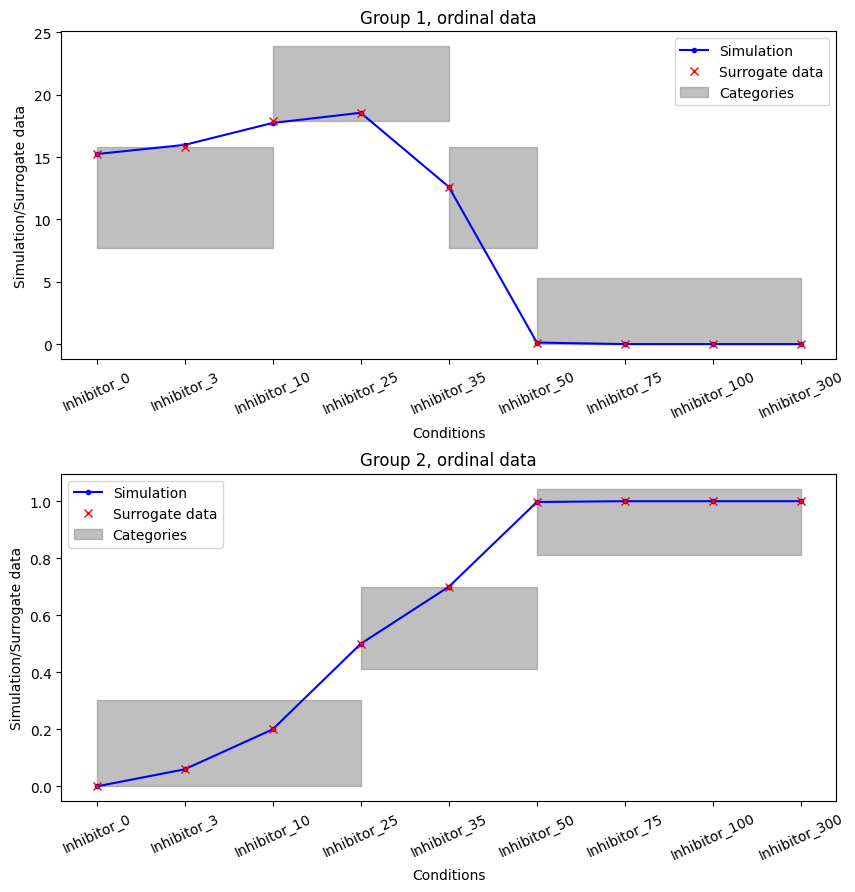

In [13]:
plot_categories_from_pypesto_result(res_standard, figsize=(10, 10))
plt.show()

In this plot we can see that all surrogate data is inside their respective categories. So the ordering given in the measurements is fully satisfied. This constitutes a perfect fit of the data in the ordinal sense.  